In [8]:
from nmigen import *
from nmigen.asserts import *
from nbmc import check, Result
from IPython.display import display


class UpCounter(Elaboratable):
    def __init__(self, limit, formal=False, formal_fail=False):
        self.formal = formal
        self.formal_fail = formal_fail
        self.limit = limit

        # Ports
        self.en  = Signal()
        self.ovf = Signal()

        # State
        self.count = Signal(16)
    
    def ports(self):
        return [self.en, self.ovf]
    
    def elab_formal(self, m):
        m.d.sync += Assert(self.count <= self.limit)
        m.d.sync += Assume(ResetSignal() == False)
        with m.If(Past(self.en) == False):
            m.d.sync += Assert(self.count == Past(self.count))
        with m.If(Past(self.en)):
            with m.If(Past(self.count) < self.limit):
                m.d.sync += Assert(self.count == Past(self.count) + 1)
            with m.Else():
                m.d.sync += Assert(self.count == 0)

    def elab_formal_fail(self, m):
        m.d.sync += Assert(self.count <= self.limit)
        m.d.sync += Assume(ResetSignal() == False)
        with m.If(Past(self.en) == False):
            m.d.sync += Assert(self.count == Past(self.count))
        with m.If(Past(self.en)):
            with m.If(Past(self.count) < self.limit):
                m.d.sync += Assert(self.count == Past(self.count) + 2)
            with m.Else():
                m.d.sync += Assert(self.count == 0)

    def elaborate(self, platform):
        m = Module()
        
        m.d.comb += self.ovf.eq(self.count == self.limit)
        with m.If(self.en):
            with m.If(self.ovf):
                m.d.sync += self.count.eq(0)
            with m.Else():
                m.d.sync += self.count.eq(self.count + 1)
      
        if self.formal:
            self.elab_formal(m)
        if self.formal_fail:
            self.elab_formal_fail(m)
        
        return m

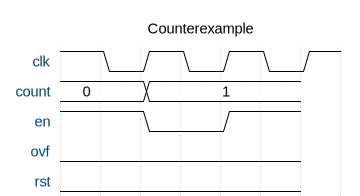

In [10]:
design = UpCounter(10, formal_fail=True)
check_run = check(design, design.ports())
if check_run.result == Result.FAIL:
    print('Fail')
    display(result.drawing)
if check_run.result == Result.PASS:
    print('PASS')